# LSTM Weather Forecasting — Fixed Pipeline + EDA + Diagnostics

This notebook includes EDA, a correct preprocessing pipeline (no scaling leakage), LSTM training with early stopping, correct inverse-scaling, evaluation metrics, and residual diagnostics.

In [1]:

# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import joblib, pickle, warnings, os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')
sns.set()


## 1) Load data and basic cleaning

In [2]:

# Load dataset (place weatherHistory.csv in same folder)
df = pd.read_csv("weatherHistory.csv")
# Parse datetimes reliably and drop rows that fail parsing
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True)
df['Formatted Date'] = df['Formatted Date'].dt.tz_convert('UTC').dt.tz_localize(None)
df = df.set_index('Formatted Date').sort_index()

# Select features used for modeling
cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']

df = df[cols].resample('D').mean().ffill().asfreq('D')
print('Data range:', df.index.min(), 'to', df.index.max())
display(df.head())


Data range: 2005-12-31 00:00:00 to 2016-12-31 00:00:00


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,
2005-12-31,0.577778,-4.050000,0.890000,17.114300,9.982000,1016.660000
2006-01-01,4.075000,-0.174537,0.817083,21.229192,11.348487,1011.985000
2006-01-02,5.263194,1.808796,0.847083,17.824713,8.492079,1010.384167
2006-01-03,2.340509,0.445370,0.897083,7.726658,9.223958,1021.170833
2006-01-04,2.251852,-0.663194,0.906667,12.152817,8.352546,981.770833


## 2) Exploratory Data Analysis

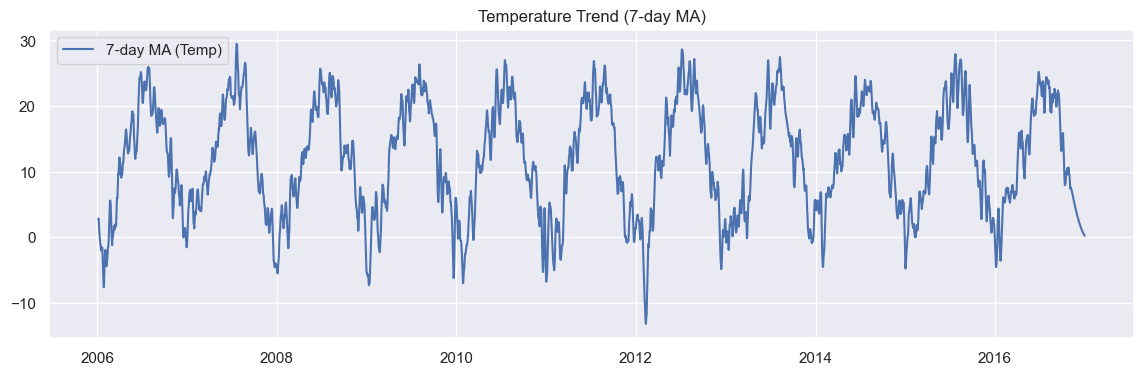

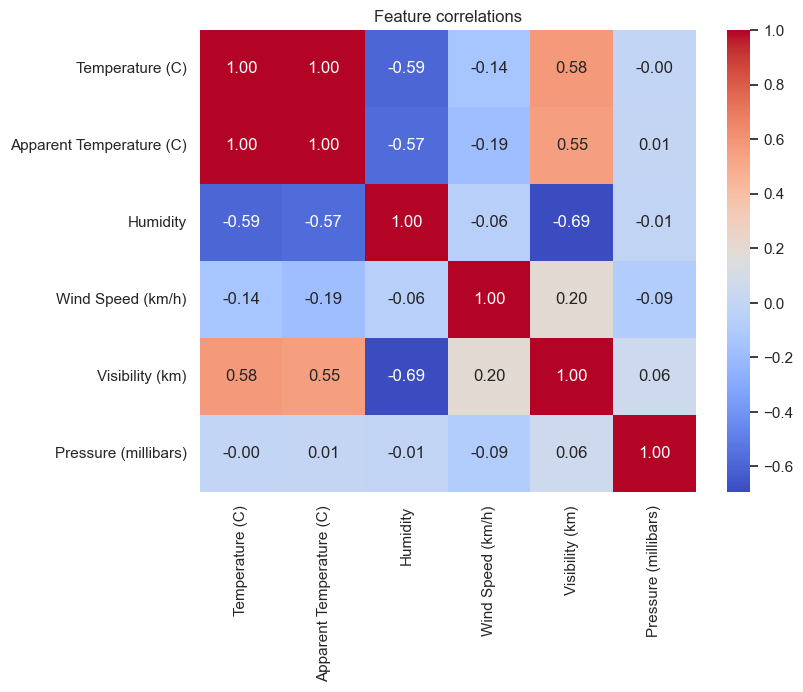

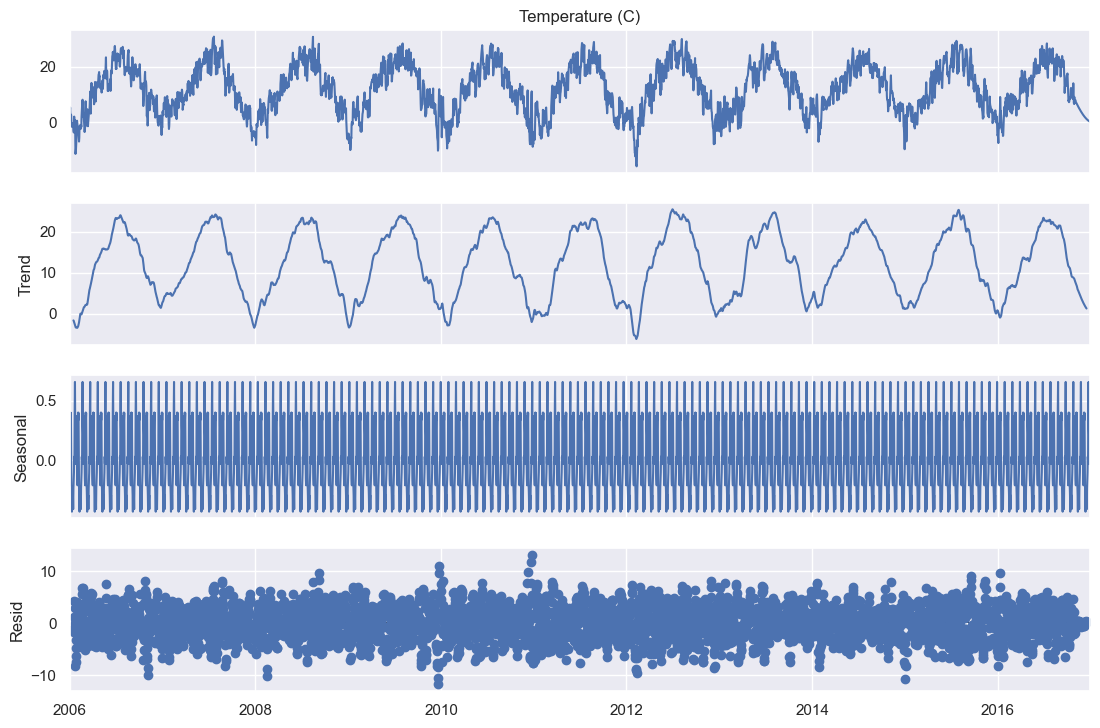

In [3]:

# Quick time series plot
plt.figure(figsize=(14,4))
plt.plot(df['Temperature (C)'].rolling(7).mean(), label='7-day MA (Temp)')
plt.title('Temperature Trend (7-day MA)'); plt.legend(); plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature correlations'); plt.show()

# Seasonal decomposition (monthly view)
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['Temperature (C)'].dropna()
res = seasonal_decompose(series, period=30, model='additive')
res.plot().set_size_inches(12,8)
plt.show()


## 3) Build sequences (no scaling yet) — create X_all, y_all from raw values

In [4]:

SEQ_LEN = 30
raw = df[cols].values  # raw values, shape (T, n_features)

# Build sequences
X_all = []
y_all = []
for i in range(len(raw) - SEQ_LEN):
    X_all.append(raw[i:i+SEQ_LEN])        # sequence of SEQ_LEN rows
    y_all.append(raw[i+SEQ_LEN, 0])      # target = temperature at next step (column 0)
X_all = np.array(X_all)
y_all = np.array(y_all)
print('Built sequences:', X_all.shape, y_all.shape)


Built sequences: (3989, 30, 6) (3989,)


## 4) Chronological train/test split and fit scaler on TRAIN only

In [5]:

# Chronological split
split = int(0.8 * len(X_all))
X_train_raw, X_test_raw = X_all[:split], X_all[split:]
y_train_raw, y_test_raw = y_all[:split], y_all[split:]
print('Train samples, Test samples:', X_train_raw.shape[0], X_test_raw.shape[0])

# Fit scaler on flattened training sequences (so scaler sees only train data)
n_features = X_train_raw.shape[2]
scaler = MinMaxScaler()
scaler.fit(X_train_raw.reshape(-1, n_features))

# Transform sequences
X_train = scaler.transform(X_train_raw.reshape(-1, n_features)).reshape(X_train_raw.shape)
X_test = scaler.transform(X_test_raw.reshape(-1, n_features)).reshape(X_test_raw.shape)

# Scale targets using same scaler (temperature is column 0)
y_train = scaler.transform(np.hstack([y_train_raw.reshape(-1,1), np.zeros((len(y_train_raw), n_features-1))]))[:,0]
y_test = scaler.transform(np.hstack([y_test_raw.reshape(-1,1), np.zeros((len(y_test_raw), n_features-1))]))[:,0]

print('X_train, X_test shapes:', X_train.shape, X_test.shape)
print('y_train/y_test shapes:', y_train.shape, y_test.shape)

# Save scaler for deployment
joblib.dump(scaler, 'scaler.save')
print('Saved scaler.save')


Train samples, Test samples: 3191 798
X_train, X_test shapes: (3191, 30, 6) (798, 30, 6)
y_train/y_test shapes: (3191,) (798,)
Saved scaler.save


## 5) Prepare chronological validation set (from training data)

In [6]:

val_size = int(0.1 * len(X_train))
if val_size < 1:
    val_size = 1
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train2 = X_train[:-val_size]
y_train2 = y_train[:-val_size]

print('Training on', X_train2.shape[0], 'samples; validating on', X_val.shape[0], 'samples')


Training on 2872 samples; validating on 319 samples


## 6) Build and train LSTM (EarlyStopping, up to 100 epochs)

In [7]:

tf.random.set_seed(42)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, n_features)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train2, y_train2, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], shuffle=False, verbose=1)

# Save model
model.save('lstm_model.h5')
print('Saved lstm_model.h5')


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0230 - val_loss: 0.0056
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 12/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0

Saved lstm_model.h5


## 7) Training history

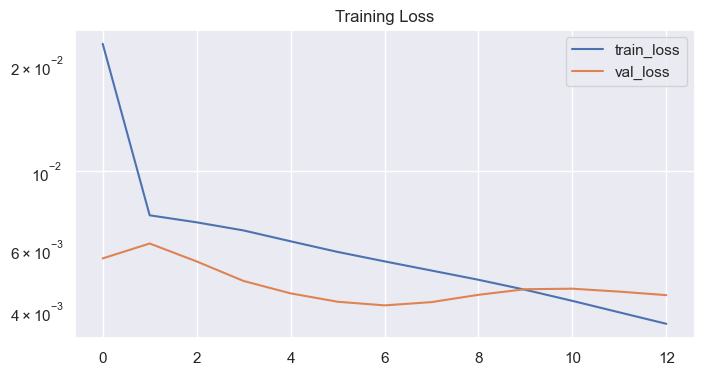

In [8]:

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend(); plt.title('Training Loss'); plt.show()


## 8) Predict on test set and inverse-scale predictions correctly

In [9]:

# Predict (scaled temperature)
y_pred_scaled = model.predict(X_test).ravel()  # shape (n_samples,)

# Build matrix for inverse transform: put predicted scaled temp in col0, use last-step other features from X_test
n_samp = X_test.shape[0]
inv_mat = np.zeros((n_samp, n_features))
inv_mat[:, 0] = y_pred_scaled
inv_mat[:, 1:] = X_test[:, -1, 1:]  # use last timestep's feature values for inverse transform context
y_pred_inv = scaler.inverse_transform(inv_mat)[:, 0]

# Inverse transform true targets for comparison
true_mat = np.zeros((n_samp, n_features))
true_mat[:, 0] = y_test  # scaled true temps
true_mat[:, 1:] = X_test[:, -1, 1:]
y_test_inv = scaler.inverse_transform(true_mat)[:, 0]

# Map test samples to dates for plotting
start_idx = SEQ_LEN + split  # first y_test corresponds to this index in original df
y_dates = df.index[start_idx : start_idx + n_samp]

print('Predictions inverse-scaled. Sample values:')
print('y_test_inv[:5]:', y_test_inv[:5])
print('y_pred_inv[:5]:', y_pred_inv[:5])


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predictions inverse-scaled. Sample values:
y_test_inv[:5]: [6.6962963  3.88541667 4.85462963 7.42569444 7.93449074]
y_pred_inv[:5]: [7.35447003 7.09738691 6.52713654 6.38952595 6.77564827]


## 9) Metrics and Forecast vs Actual plot

MAE: 2.515, RMSE: 3.237, MAPE: 65.36%


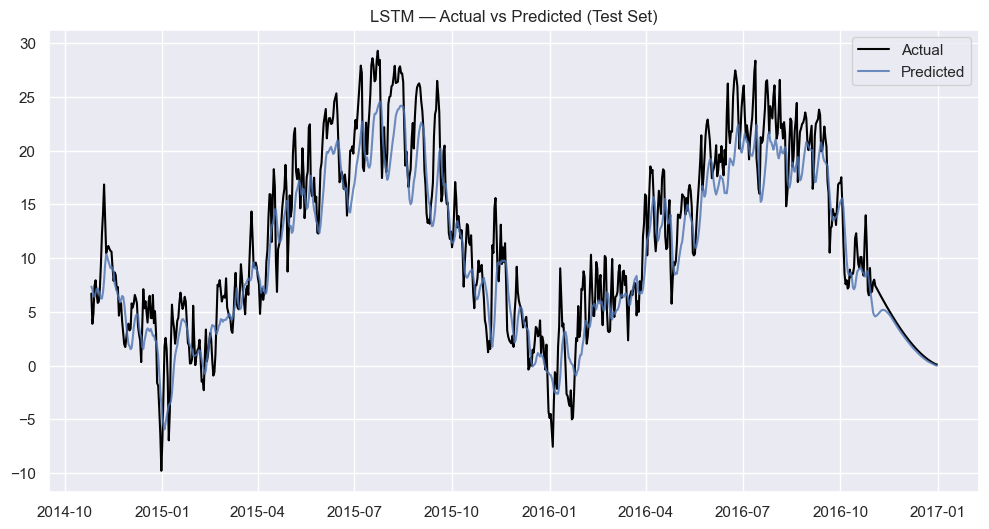

In [10]:

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%')

plt.figure(figsize=(12,6))
plt.plot(y_dates, y_test_inv, label='Actual', color='black')
plt.plot(y_dates, y_pred_inv, label='Predicted', alpha=0.8)
plt.legend(); plt.title('LSTM — Actual vs Predicted (Test Set)'); plt.show()


## 10) Residual diagnostics: histogram & ACF

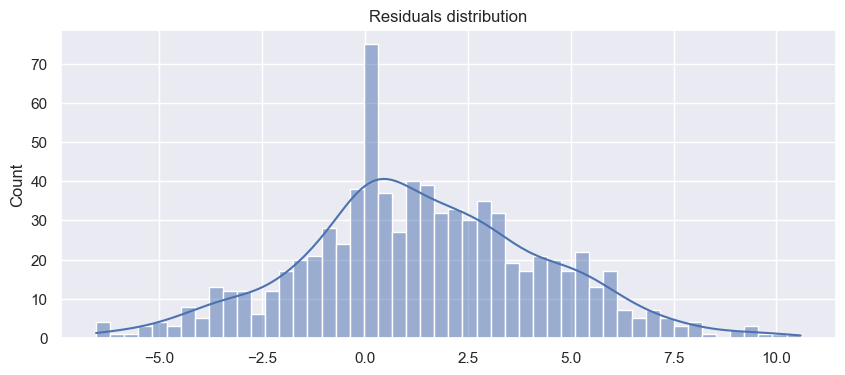

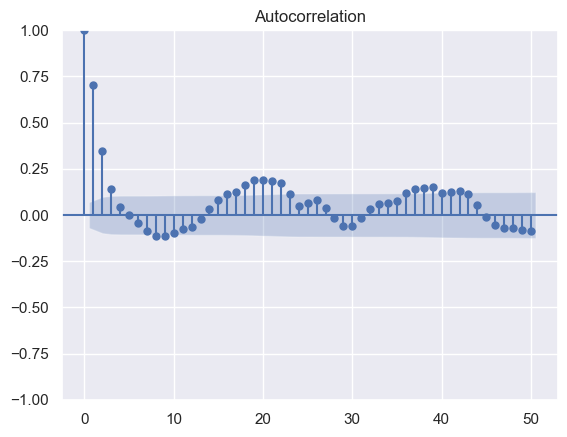

Saved lstm_test_predictions.csv


In [11]:

residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(10,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals distribution'); plt.show()

# ACF of residuals
plot_acf(residuals, lags=50); plt.show()

# Save predictions to csv for inspection
out_df = pd.DataFrame({'date': y_dates, 'actual': y_test_inv, 'predicted': y_pred_inv, 'residual': residuals})
out_df.to_csv('lstm_test_predictions.csv', index=False)
print('Saved lstm_test_predictions.csv')
